# Attribution

In this notebook, I am applying the pretrained model from Jeremy Howard & Sebastian Ruder's paper "Universal Language Model Fine-tuning for Text Classification" (https://arxiv.org/abs/1801.06146) to the twitter airline sentiment dataset from Kaggle (https://www.kaggle.com/crowdflower/twitter-airline-sentiment/downloads/twitter-airline-sentiment.zip/2). In my implementation I am borrowing from fastai's tutorial on ULMFiT (https://docs.fast.ai/text.html).

# Imports

To load and fine-tune the pre-trained ULMFiT model, I am using the `fastai` library. 

In [1]:
import re
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import fastai
from fastai import *
from fastai.text import *
from sklearn.model_selection import train_test_split

stopwords = set(stopwords.words('english'))

# Data


### Exploration

In [4]:
# Loading the data I had downloaded from the kaggle website
data = pd.read_csv("Tweets.csv")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
# 25 most common words
Counter([x for y in data["text"] for x in y.split(" ")]).most_common(25)

[('to', 8535),
 ('the', 5781),
 ('I', 5047),
 ('a', 4358),
 ('for', 3920),
 ('@united', 3638),
 ('on', 3551),
 ('and', 3544),
 ('you', 3232),
 ('my', 3035),
 ('@AmericanAir', 2848),
 ('@USAirways', 2848),
 ('flight', 2597),
 ('is', 2579),
 ('in', 2397),
 ('@SouthwestAir', 2344),
 ('', 2173),
 ('of', 2093),
 ('@JetBlue', 1973),
 ('have', 1545),
 ('your', 1543),
 ('me', 1536),
 ('was', 1531),
 ('with', 1469),
 ('at', 1433)]

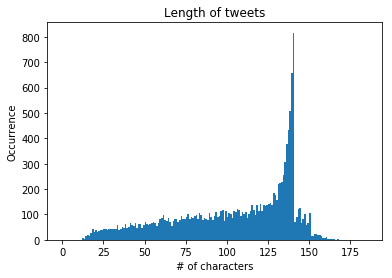

In [6]:
# Length of tweets
tweet_lengths = [len(x) for x in data["text"]]
plt.hist(tweet_lengths, bins=list(range(max(tweet_lengths))))
plt.title("Length of tweets")
plt.xlabel("# of characters")
plt.ylabel("Occurrence")
plt.show()

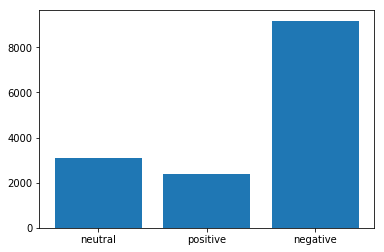

In [7]:
# Sentiment distribution
sentiment = Counter(data["airline_sentiment"])
plt.bar(range(len(sentiment)), list(sentiment.values()), align='center')
plt.xticks(range(len(sentiment)), list(sentiment.keys()))
plt.show()

### Processing


After looking at the dataset, I decided to apply the ULMFiT model to predict the sentiment (`airline_sentiment`) based on the tweet (`text`). I therefore narrow the data down to the two columns of interest. I had tried processing the tweets by only keeping letters and removing all stopwords, but this resulted in lower accuracy. I hypothesize that the reasons stems from the brief nature of tweets, which often use punctuation (including emojis) to express meaning.  

In [9]:
# COMMENTED OUT SINCE IT DIDN'T IMPROVE RESULTS
# tweets = data['text'].str.replace("[^a-zA-Z]", " ")
# tweets = data['text'].apply(lambda y: [x for x in word_tokenize(y) if x.lower() not in stopwords])
# tweets = tweets.apply(lambda y: " ".join(y))
# tweets = [re.sub(' +', ' ', x).lower() for x in data['text']]

In [10]:
tweets = data['text']

In [11]:
df = pd.DataFrame({"Tweet": tweets, "Sentiment": data["airline_sentiment"]})
df.head()

,Sentiment,Tweet
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


Next, I split my data into a training and a validation set, stratifying due to the uneven distribution of the outcome variable.

In [12]:
train, valid = train_test_split(df, stratify=df["Sentiment"], test_size=0.33, random_state=0)

# Language Model

Now I load and fine-tune the pretrained model, saving the encoder for the upcoming classification model.

In [14]:
lang_data = TextLMDataBunch.from_df(train_df=train, valid_df=valid, path="")
learn_lang = language_model_learner(lang_data, drop_mult=0.5, arch=AWD_LSTM)
learn_lang.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.978205,4.210239,0.229762,08:22


In [15]:
learn_lang.unfreeze()
learn_lang.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.037210,3.834553,0.277447,17:15


In [16]:
learn_lang.save_encoder('encoder')

# Classification Model

With the saved encoder, I now fine-tune the model to the airline tweet dataset.

In [18]:
class_data = TextClasDataBunch.from_df(
    path = "", train_df = train, valid_df = valid, vocab=lang_data.train_ds.vocab, bs=32
)
learn_class = text_classifier_learner(class_data, AWD_LSTM, drop_mult=0.5)
learn_class.load_encoder('encoder')

In [19]:
class_data.show_batch()

text,target
xxbos @united xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup san68059 m,negative
xxbos @united - xxmaj kids left a kindle fire xxup hd 6 onboard xxup xxunk ( xxup ord - xxup sfo ) today . xxmaj row xxup xxunk - xxup def ( we had the whole row xxunk the 5 of us ) . xxmaj help ...,neutral
xxbos @americanair xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup gma up here this xxup am .. so i understand .. xxmaj btw xxup a.a is my xxmaj airline when i m able to trv .. xxmaj love you guys . : ),positive
"xxbos @united xxmaj waiting for xxunk xxup ewr - xxup ord , delayed 47 mins . xxmaj might miss xxunk xxup ord - xxup ywg at 6 pm xxup ct . xxmaj any room on xxunk xxup ord - xxup ywg in case i miss xxunk ?",negative
"xxbos @southwestair xxmaj loved one 's flight xxup atl to xxup ind xxmaj cancelled xxmaj flightled due to "" ice in xxmaj indy "" . xxmaj sitting here in xxmaj indy , it is xxunk dry . xxmaj tomorrow 4 - 6 "" of snow .",negative


In [20]:
learn_class.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.662886,0.563268,0.772972,06:52


In [21]:
learn_class.freeze_to(-2)
learn_class.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.637515,0.539107,0.773593,08:25


In [22]:
learn_class.unfreeze()
learn_class.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.541633,0.502979,0.800290,27:06


# Results

The model achieves an accuracy of around 80%. Pre-processing the data (removing stopwords and/or punctuation) did not improve accuracy, but in fact lessened it. We can also use the model to predict the sentiment of new reviews like the made-up ones below:

In [23]:
learn_class.predict("My flight was great! Top service, fun entertainment -- only the legroom is a bit small")

(Category positive, tensor(2), tensor([0.0609, 0.0064, 0.9326]))

In [24]:
learn_class.predict("What a terrible experience :( I'll never fly with this airline again.")

(Category negative, tensor(0), tensor([0.8785, 0.0471, 0.0743]))

In [25]:
learn_class.predict("I am doing a research paper on airlines and I have compared several. Check out my results!")

(Category neutral, tensor(1), tensor([0.3116, 0.5790, 0.1093]))

# Extensions

Through the process of working on this problem, I also thought about the following extensions to the analysis: 
<br> - Play around with the number of epochs, learning rate, drop-out, etc. (using GPU on Google Colab)
<br> - Factor in `airline_sentiment_confidence` (e.g. as threshold or weights in training)
<br> - Try transformers instead of lstm structure